,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,relative_time
relative_time,,,,,,,,,
0 days 05:37:07.968000,1325.826864,1325.813107,2047.908650,2666.700597,6520.285557,-544.947131,-836.327659,1419.076329,0.734117
1 days 05:37:07.968000,1326.837287,1326.823520,5345.087787,2702.199550,6170.744729,-352.821054,-156.081096,1438.067577,1.744530
2 days 05:37:07.968000,1327.836387,1327.822614,2630.909821,2658.526017,6037.150628,-1476.642241,-1440.897278,1414.847357,2.743624
3 days 05:37:07.968000,1328.837299,1328.823520,317.029136,2634.000730,3988.201185,-1620.062427,-1828.118435,1401.815779,3.744530
4 days 05:37:07.968000,1329.837304,1329.823520,389.116118,2620.245259,4540.132852,-1918.819517,-1920.969165,1394.497719,4.744530
5 days 05:37:07.968000,1330.858142,1330.844353,-1637.727234,2603.872840,2765.333911,-1590.884470,-1470.572515,1385.787202,5.765363
6 days 05:37:07.968000,1331.837311,1331.823520,-1729.704001,2597.980817,2366.855204,-1853.372733,-1999.316573,1382.652144,6.744530
7 days 05:37:07.968000,1332.836408,1332.822614,-2325.313295,2602.857492,2310.894570,-1637.303830,-1955.100291,1385.245930,7.743624
8 days 05:37:07.968000,1333.837316,1333.823520,-1143.832671,2603.243481,2759.291687,-1589.340558,-1450.979167,1385.452877,8.744530


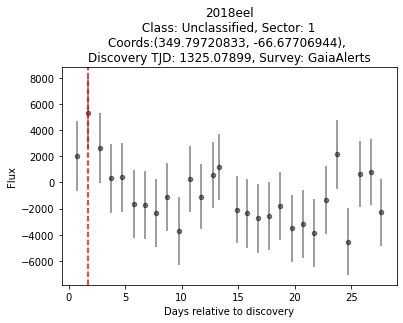

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import extinction
from astroquery.ipac.irsa.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u
import keras

def preprocess(filename, display=False):
    # lightcurve data
    curve = pd.read_csv("./TESS_data/light_curves_fausnaugh/" + filename, delim_whitespace=True)
    curve_name = filename.split("_")[1]
    # information about transient
    curve_meta = transients[transients['IAU'] == curve_name]
    if curve_meta.empty:
        return None, None

    # convert time to relative to discovery
    curve['relative_time'] = curve['TJD'] - curve_meta["TJD_discovery"].iloc[0]
    curve.index = pd.TimedeltaIndex(curve['relative_time'], unit="D")

    # sigma clipping
    for _ in range(0, 5):
        uncert_mean = curve.e_cts.mean()
        threshold = 3*curve.e_cts.std()
        curve = curve[np.abs(curve['e_cts'] - uncert_mean) <= threshold]

    # sub bg flux
    if not curve['bkg_model'].isnull().all():
        curve['cts'] = curve['cts'] - curve['bkg_model']

    # correct milky way extinction
    # Set relevant parameters
    ra = curve_meta["ra"].iloc[0]
    dec = curve_meta["dec"].iloc[0]
    flux_in = curve["cts"]
    fluxerr_in = curve["e_cts"]
    bandpass_wavelengths = np.array([786.5,])

    # Get Milky Way E(B-V) Extinction
    coo = coord.SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
    dust = IrsaDust.get_query_table(coo, section='ebv')
    mwebv = dust['ext SandF mean'][0]

    # Remove extinction from light curves
    # (Using negative a_v so that extinction.apply works in reverse and removes the extinction)
    extinction_per_passband = extinction.fitzpatrick99(wave=bandpass_wavelengths, a_v=-3.1 * mwebv, r_v=3.1, unit='aa')
    flux_out = extinction.apply(extinction_per_passband[0], flux_in, inplace=False)
    fluxerr_out = extinction.apply(extinction_per_passband[0], fluxerr_in, inplace=False)

    curve['cts'] = flux_out
    curve['e_cts'] = fluxerr_out

    # bin
    #square e_cts to get variances
    curve['e_cts'] = np.power(curve['e_cts'], 2)
    #find avg cnts and avg variances
    curve = curve.resample(bin_interval).mean()
    #sqrt avg vars to get uncertainty in stds
    curve['e_cts'] = np.power(curve['e_cts'], 0.5)

    id_max = curve["cts"].idxmax()
    max_data = curve.loc[id_max, :]
    t_max = max_data['relative_time']

    if display:
        plot_title = f"{curve_name}\n Class: {curve_meta['class'].iloc[0]}, Sector: {curve_meta['sector'].iloc[0]} \nCoords:{curve_meta['ra'].iloc[0], curve_meta['dec'].iloc[0]}, \nDiscovery TJD: {curve_meta['TJD_discovery'].iloc[0]}, Survey: {curve_meta['survey'].iloc[0]}"
        ax = curve.plot.scatter(x="relative_time", y='cts', c="00000", alpha=0.5, yerr='e_cts', ylabel="Flux", xlabel="Days relative to discovery", title=plot_title)
        ax.axvline(t_max, color="red", linestyle="--")

    return curve, t_max


transients = pd.read_csv("./TESS_data/AT_count_transients_s1-47 (4).txt", names=["sector", "ra", "dec", "mag", "TJD_discovery", "type" ,"class", "IAU", "survey", "cam", "ccd", "col", "row"], delim_whitespace=True)
light_curves = os.listdir("./TESS_data/light_curves_fausnaugh")

#adjusts length of bins, eg. M:months, D:days, T: minutes, S: seconds,
# more doc: https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html#pandas.Series.resample
bin_interval = "1D"
test_index = 0

test, t_max = preprocess(light_curves[test_index], display=True)
test

In [15]:
no_info = []
for file in light_curves:
    print(file)
    light_curve, max_light = preprocess(file)

    # light curves with no data about them AT_count
    if light_curve is None:
        no_info.append(file)

print(no_info)
input_image = None #TODO

lc_2018eel_cleaned
lc_2018emt_cleaned
lc_2018eny_cleaned
lc_2018eoa_cleaned
lc_2018eoc_cleaned
lc_2018eod_cleaned
lc_2018eph_cleaned
lc_2018eqo_cleaned
lc_2018esp_cleaned
lc_2018esw_cleaned
lc_2018evo_cleaned
lc_2018exc_cleaned
lc_2018fbm_cleaned
lc_2018fdw_cleaned
lc_2018fdx_cleaned
lc_2018fgb_cleaned
lc_2018fhs_cleaned
lc_2018fhw_cleaned
lc_2018fhw_detrended_cleaned
lc_2018flj_cleaned
lc_2018fll_cleaned
lc_2018flq_cleaned
lc_2018flr_cleaned
lc_2018flt_cleaned
lc_2018flz_cleaned
lc_2018fmg_cleaned
lc_2018fmm_cleaned
lc_2018fmn_cleaned
lc_2018fns_cleaned
lc_2018fqn_cleaned
lc_2018ftf_cleaned
lc_2018fub_cleaned
lc_2018fvi_cleaned
lc_2018fvi_detrended_cleaned
lc_2018fwd_cleaned
lc_2018fwi_cleaned
lc_2018fwk_cleaned
lc_2018fwm_cleaned
lc_2018fwr_cleaned
lc_2018fxj_cleaned
lc_2018fxl_cleaned
lc_2018fzi_cleaned
lc_2018gey_cleaned
lc_2018gfj_cleaned
lc_2018gfk_cleaned
lc_2018gku_cleaned
lc_2018glp_cleaned
lc_2018glq_cleaned
lc_2018glv_cleaned
lc_2018glw_cleaned
lc_2018goa_cleaned
lc_2018gqc_